C:\Users\coimb\AppData\Local\Temp\ipykernel_25496\1456029240.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metadados_iv = metadados_iv._append({'variavel': var, 'IV': iv}, ignore_index=True)


        variavel        IV
8   valor_nf_q50  0.121407
7   valor_nf_q20  0.078175
6   valor_nf_q10  0.059045
5   valor_nf_q05  0.038969
2        dia_mes  0.015080
4      trimestre  0.009916
3            mes  0.009086
0     dia_semana  0.005873
1  fim_de_semana  0.004597


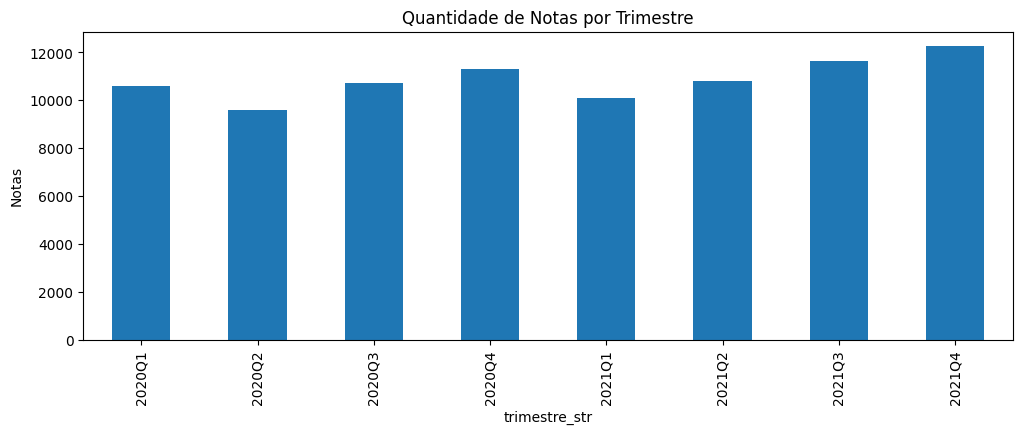

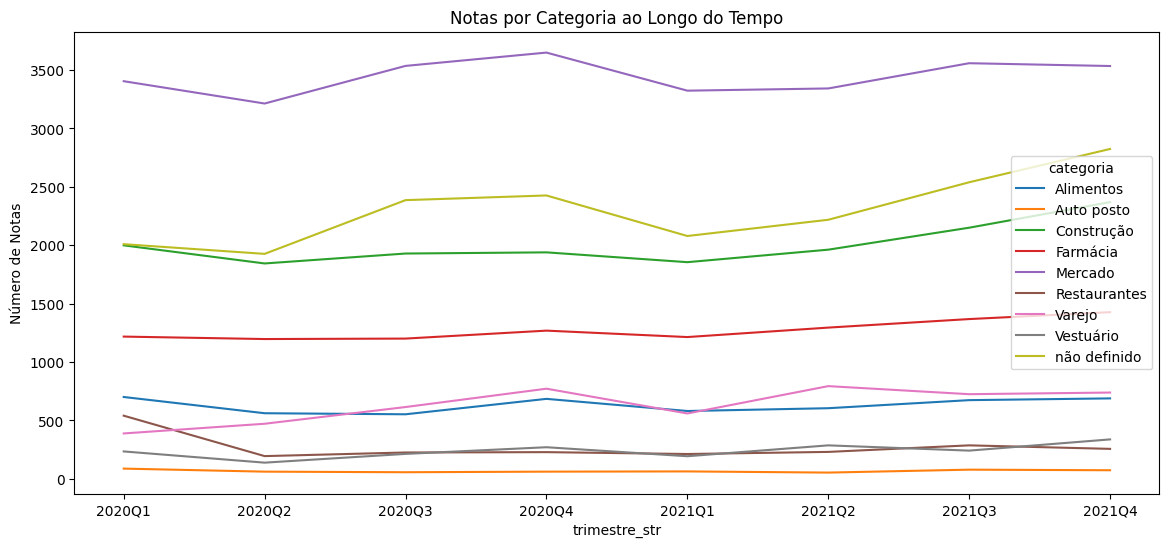

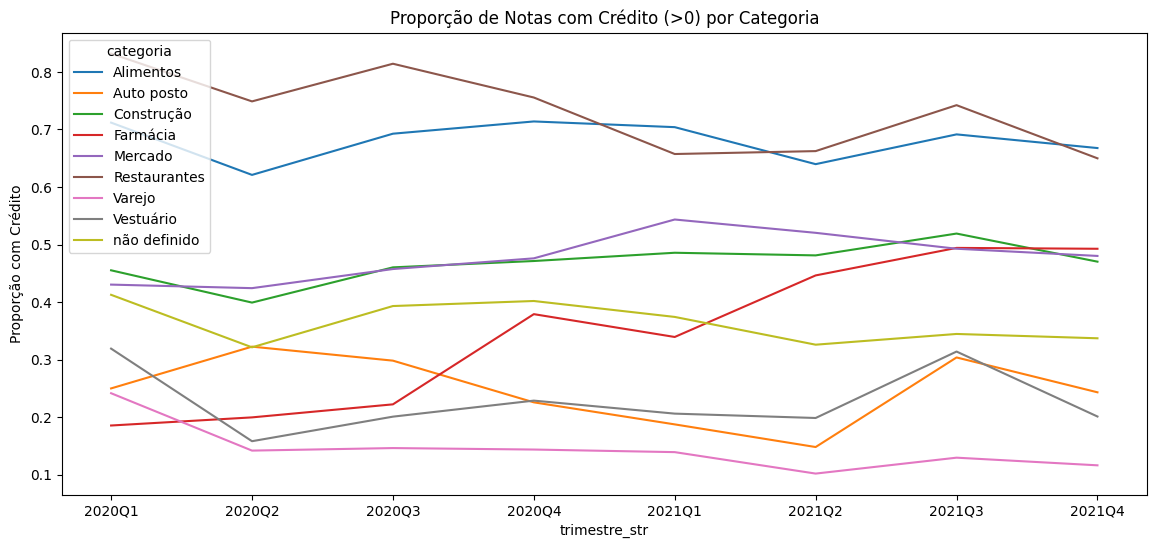

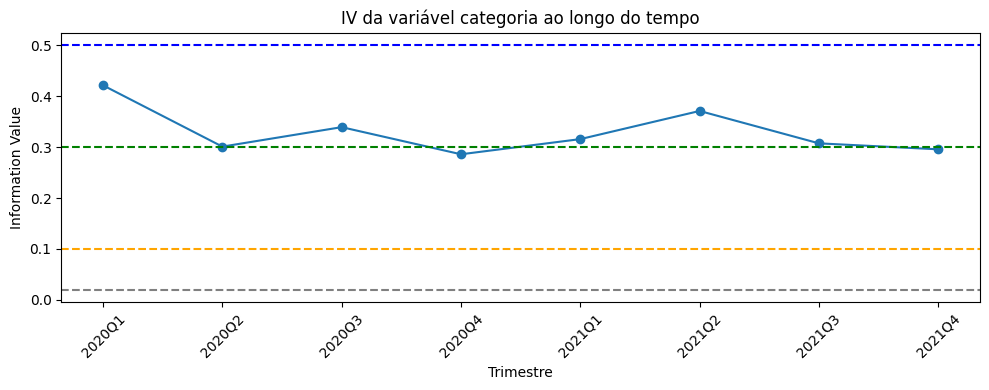

In [1]:
# Tarefa II - Nota Fiscal Paulista: Análise de WoE, IV e Estabilidade no Tempo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregamento da base e filtragem a partir de 2020
df = pd.read_pickle("base_nfp.pkl")
df = df[df["Data Emissão"] >= "2020-01-01"].copy()
df["flag_credito"] = (df["Retorno"] > 0).astype(int)

# Criação de variáveis temporais
df['dia_semana'] = df['Data Emissão'].dt.dayofweek
df['fim_de_semana'] = df['dia_semana'].isin([5, 6]).astype(int)
df['dia_mes'] = df['Data Emissão'].dt.day
df['mes'] = df['Data Emissão'].dt.month
df['trimestre'] = df['Data Emissão'].dt.to_period("Q")
df['ano'] = df['Data Emissão'].dt.year

# Categorizacao de Valor NF
for q in [5, 10, 20, 50]:
    df[f'valor_nf_q{q:02}'] = pd.qcut(df['Valor NF'], q, duplicates='drop')

# Função para WoE e IV
def calculate_woe_iv(df, feature, target='flag_credito'):
    eps = 1e-4
    tab = pd.crosstab(df[feature], df[target])
    tab.columns = ['No_Event', 'Event'] if 0 in tab.columns else ['Event', 'No_Event']
    tab['Dist_Event'] = tab['Event'] / tab['Event'].sum()
    tab['Dist_No_Event'] = tab['No_Event'] / tab['No_Event'].sum()
    tab['WoE'] = np.log((tab['Dist_Event'] + eps) / (tab['Dist_No_Event'] + eps))
    tab['IV'] = (tab['Dist_Event'] - tab['Dist_No_Event']) * tab['WoE']
    return tab.reset_index(), tab['IV'].sum()

# Cálculo do IV para variáveis criadas
variaveis = ['dia_semana', 'fim_de_semana', 'dia_mes', 'mes', 'trimestre',
             'valor_nf_q05', 'valor_nf_q10', 'valor_nf_q20', 'valor_nf_q50']

metadados_iv = pd.DataFrame(columns=['variavel', 'IV'])

for var in variaveis:
    _, iv = calculate_woe_iv(df, var)
    metadados_iv = metadados_iv._append({'variavel': var, 'IV': iv}, ignore_index=True)

# Descritiva temporal
df['trimestre_str'] = df['trimestre'].astype(str)
qtd_notas = df.groupby('trimestre_str')['No.'].count()
qtd_por_categoria = df.groupby(['trimestre_str', 'categoria'])['No.'].count().unstack().fillna(0)
proporcao_credito = df.groupby(['trimestre_str', 'categoria'])['flag_credito'].mean().unstack().fillna(0)

# WoE e IV no tempo da variável categoria
tab = df.groupby(['trimestre_str', 'categoria'])['flag_credito'].value_counts().unstack().fillna(0)
tab.columns = ['nao', 'sim']
tab['pct_evento'] = tab['sim'] / tab['sim'].groupby(level=0).sum()
tab['pct_nao_evento'] = tab['nao'] / tab['nao'].groupby(level=0).sum()
tab['WOE'] = np.log((tab['pct_evento'] + 1e-4) / (tab['pct_nao_evento'] + 1e-4))
tab['IV_parcial'] = (tab['pct_evento'] - tab['pct_nao_evento']) * tab['WOE']
iv_categoria = tab['IV_parcial'].groupby(level=0).sum()

# Função de plotagem IV

def plot_iv(iv):
    fig, ax = plt.subplots(figsize=(10, 4))
    x = iv.index
    ax.plot(x, iv, marker='o')
    ax.axhline(0.02, color='gray', linestyle='--')
    ax.axhline(0.1, color='orange', linestyle='--')
    ax.axhline(0.3, color='green', linestyle='--')
    ax.axhline(0.5, color='blue', linestyle='--')
    ax.set_title("IV da variável categoria ao longo do tempo")
    ax.set_ylabel("Information Value")
    ax.set_xlabel("Trimestre")
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

# Exibe resultados
print(metadados_iv.sort_values(by='IV', ascending=False))
qtd_notas.plot(kind='bar', figsize=(12, 4), title="Quantidade de Notas por Trimestre")
plt.ylabel("Notas")
plt.show()

qtd_por_categoria.plot(kind='line', figsize=(14, 6), title="Notas por Categoria ao Longo do Tempo")
plt.ylabel("Número de Notas")
plt.show()

proporcao_credito.plot(kind='line', figsize=(14, 6), title="Proporção de Notas com Crédito (>0) por Categoria")
plt.ylabel("Proporção com Crédito")
plt.show()

plot_iv(iv_categoria)  # IV por trimestre
